###**Mounting Google Drive**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
rand_state = 42

###**Import Libraries**

In [3]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_score,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [4]:
from sklearn.metrics import confusion_matrix
def plot_conf_matrix(y_test,y_pred,uniqueclassLabel, title="CMatrix"):
  cm = confusion_matrix(y_true=y_test,y_pred=y_pred,labels=uniqueclassLabel)
  plt.figure(figsize=(5,4))
  plt.title(title)
  #ax = plt.subplot()
  sns.heatmap(cm, annot=True,cmap='Blues',
              yticklabels=uniqueclassLabel,xticklabels=uniqueclassLabel,fmt='3g')

###**Import Utility File**

In [5]:
# import sys
# path = "/content/drive/MyDrive/Colab Notebooks/Project_Dissertation"
# sys.path.insert(0,path + "/Code")
# import morningStarUtilities

user = 'nishitgala89'
repo = 'ProjectDissertation'
src_dir = "Code/utilities"
pyfile = "morningStarUtilities.py"

url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url}

import morningStarUtilities

--2022-01-06 15:04:22--  https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Code/utilities/morningStarUtilities.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6484 (6.3K) [text/plain]
Failed to rename morningStarUtilities.py to morningStarUtilities.py.1: (2) No such file or directory
Saving to: ‘morningStarUtilities.py’

morningStarUtilitie 100%[===================>]   6.33K  --.-KB/s    in 0s      

2022-01-06 15:04:22 (53.8 MB/s) - ‘morningStarUtilities.py’ saved [6484/6484]



### **Import Training Data**

In [6]:
train_df = pd.read_csv("https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Datasheets/3_Modelling/morningstar_removedDuplicates_train_withoutLogTransform_withoutM60.csv").set_index("SecId")

### **Import Testing Data**

In [7]:
# uploaded = files.upload()
# test_df = pd.read_csv(io.BytesIO(uploaded['morningstar_removedDuplicates_test_withoutM60.csv']))

In [8]:
test_df = pd.read_csv('https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Datasheets/3_Modelling/morningstar_removedDuplicates_test_withoutLogTransform_withoutM60.csv').set_index("SecId")

### **Defining Training, Testing varibales**

In [9]:
train_df['Rank'] = -1
test_df['Rank'] = -1

In [10]:
train_df['Rank'] = train_df['StarRatingM255'].apply(lambda x : 2 if(x in (1,2)) else (4 if(x in (4,5)) else 3))
test_df['Rank'] = test_df['StarRatingM255'].apply(lambda x : 2 if(x in (1,2)) else (4 if(x in (4,5)) else 3))

In [11]:
train_df.Rank.value_counts(dropna=False)

3    320
4    309
2    257
Name: Rank, dtype: int64

In [12]:
test_df.Rank.value_counts(dropna=False)

4    117
3     97
2     82
Name: Rank, dtype: int64

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 886 entries, F000005ETU to F00000M89N
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Name                       886 non-null    object 
 1   StarRatingM255             886 non-null    int64  
 2   SustainabilityRank         886 non-null    int64  
 3   Yield_M12                  886 non-null    float64
 4   GBRReturnW1                886 non-null    float64
 5   GBRReturnM1                886 non-null    float64
 6   GBRReturnM3                886 non-null    float64
 7   GBRReturnM6                886 non-null    float64
 8   GBRReturnM0                886 non-null    float64
 9   GBRReturnM12               886 non-null    float64
 10  GBRReturnM36               886 non-null    float64
 11  MaxFrontEndLoad            886 non-null    float64
 12  OngoingCostActual          886 non-null    float64
 13  TransactionFeeActual       886 non-null

In [14]:
imp_features = ['SustainabilityRank','GBRReturnM1','GBRReturnM3','GBRReturnM0','GBRReturnM36','OngoingCostActual','TransactionFeeActual','FundTNAV',
                'AverageMarketCapital','MorningstarRiskM255','AlphaM36','BetaM36','StandardDeviationM36','SharpeM36','Size','Style']

X_train = train_df[imp_features]
y_train = train_df['Rank']

X_test = test_df[imp_features]
y_test = test_df['Rank']

In [15]:
X_train.shape, y_train.shape

((886, 16), (886,))

In [16]:
# X_train = train_df.drop(['StarRatingM255','Name'],axis=1)
# y_train = train_df[['StarRatingM255']]
# X_test = test_df.drop(['StarRatingM255','Name'],axis=1)
# y_test = test_df[['StarRatingM255']]
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

### **Scaling the Data**

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Verify the Training and Testing distribution as per Target Variable**

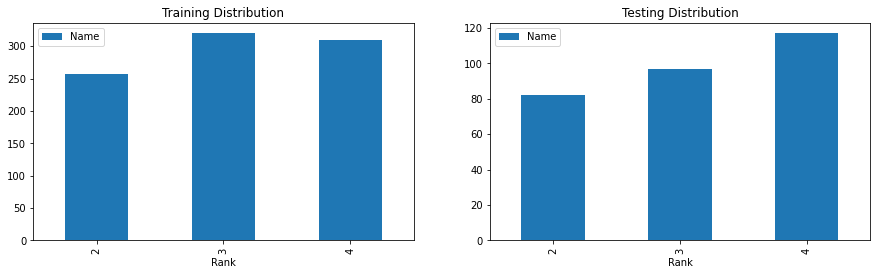

In [18]:
morningStarUtilities.displayBarSubPlots([train_df,test_df],["Training Distribution", "Testing Distribution"],
                   "Rank")

### **Creating runtime variables**

In [19]:
unique_class_label = list(train_df.Rank.unique())
unique_class_label.sort()
unique_class_label

[2, 3, 4]

In [20]:
cv_accuracy_metrics = []
cv_balanced_metrics = []
cv_f1_metrics = []

In [21]:
cv_mean = []
cv_std = []
cv_bal_mean = []
cv_bal_std = []
f1_w_mean = []
f1_w_std = []

### **Defining Classifiers**

In [22]:
#!pip install catboost

In [23]:
#from catboost import CatBoostClassifier
clfs = []
clfs.append(RandomForestClassifier(n_estimators=350,max_depth=8, max_features=0.64,
                                    random_state=rand_state, criterion="entropy"))
# clfs.append(CatBoostClassifier(verbose=False, random_state=rand_state, learning_rate=0.01, loss_function='MultiClass',
#                                n_estimators =300))
clfs.append(XGBClassifier(n_estimators=250, max_depth=10, random_state=rand_state,verbose=1,learning_rate=0.001,
                           verbosity=1,booster='dart', normalize_type='forest', rate_drop = 0.3, subsample = 0.4,
                           objective='multi:softprob'))
clfs.append(LogisticRegression(max_iter=1000,random_state=rand_state ))
# clfs.append(SVC(probability=True, random_state=rand_state,class_weight=class_wt))
clfs.append(GradientBoostingClassifier(n_estimators= 400,random_state=rand_state,learning_rate=0.005, max_features = 0.64, min_samples_split=10, min_samples_leaf=25))
len(clfs)

4

### **5-Fold Cross Validation**

In [24]:
scaled_clf = ['LogisticRegression', 'SVC', 'BaggingClassifier']
skf = StratifiedKFold(n_splits=5, random_state=rand_state, shuffle=True)
for clf in clfs:
  if clf.__class__.__name__ in scaled_clf:
    cv_accuracy_metrics.append(cross_val_score(clf, X_train_scaled, y_train, scoring = 'accuracy',
                                      cv = skf,verbose=2,n_jobs=-1))
    cv_balanced_metrics.append(cross_val_score(clf, X_train_scaled, y_train, scoring = 'balanced_accuracy', 
                                      cv = skf,verbose=2,n_jobs=-1))
    cv_f1_metrics.append(cross_val_score(clf, X_train_scaled, y_train, scoring = 'f1_weighted', 
                                      cv = skf,verbose=2,n_jobs=-1))
  
  else:

    cv_accuracy_metrics.append(cross_val_score(clf, X_train, y_train, scoring = 'accuracy',
                                      cv = skf,verbose=2,n_jobs=-1))
    cv_balanced_metrics.append(cross_val_score(clf, X_train, y_train, scoring = 'balanced_accuracy', 
                                      cv = skf,verbose=2,n_jobs=-1))
    cv_f1_metrics.append(cross_val_score(clf, X_train, y_train, scoring = 'f1_weighted', 
                                      cv = skf,verbose=2,n_jobs=-1))
for clf_result in cv_accuracy_metrics:
  cv_mean.append(clf_result.mean())
  cv_std.append(clf_result.std())

for clf_result in cv_balanced_metrics:
  cv_bal_mean.append(clf_result.mean())
  cv_bal_std.append(clf_result.std())

for clf_result in cv_f1_metrics:
  f1_w_mean.append(clf_result.mean())
  f1_w_std.append(clf_result.std())

result_df = pd.DataFrame({'Classifier' :  [clf.__class__.__name__  for clf in clfs],
                          'CV_Accuracy Mean': cv_mean,'CV_Accuracy Std' : cv_std,
                          'CV_Bal_Accuracy Mean': cv_bal_mean,'CV_Bal_Accuracy Std' : cv_bal_std,
                          'CV_f1_weighted Mean': f1_w_mean,'V_f1_weighted Std' : f1_w_std
                          })

result_df.sort_values(by='CV_Accuracy Mean',ascending=False, ignore_index=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_

,Classifier,CV_Accuracy Mean,CV_Accuracy Std,CV_Bal_Accuracy Mean,CV_Bal_Accuracy Std,CV_f1_weighted Mean,V_f1_weighted Std
0,RandomForestClassifier,0.660325,0.046458,0.663822,0.047219,0.658906,0.046838
3,GradientBoostingClassifier,0.654688,0.036711,0.656093,0.037330,0.654416,0.035906
1,XGBClassifier,0.653571,0.039775,0.657304,0.040823,0.653953,0.037605
2,LogisticRegression,0.636596,0.029439,0.640252,0.030476,0.638136,0.028590


## **Prediction Run**

Accuracy Score for RandomForestClassifier  0.6722972972972973
F1 Score for RandomForestClassifier  0.6717199310543835
Accuracy Score for XGBClassifier  0.7128378378378378
F1 Score for XGBClassifier  0.7144406410952197
Accuracy Score for LogisticRegression  0.6756756756756757
F1 Score for LogisticRegression  0.6755004092406979
Accuracy Score for GradientBoostingClassifier  0.7162162162162162
F1 Score for GradientBoostingClassifier  0.7168295203548707


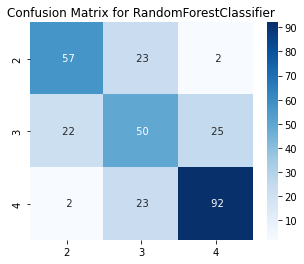

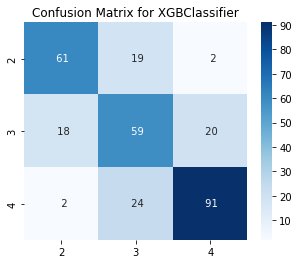

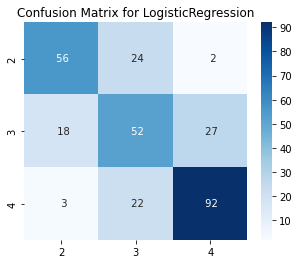

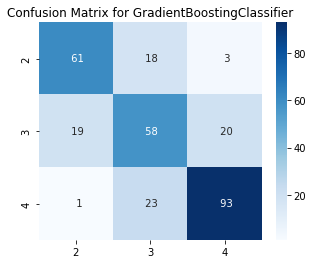

In [25]:
test_acc_score=[]
test_f1_score=[]
clfList = [clf.__class__.__name__  for clf in clfs]


def run_predict(clf):
  if clf.__class__.__name__ == "LogisticRegression":
    clf = clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
  else:
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
  plot_conf_matrix(y_test,y_pred,unique_class_label, title="Confusion Matrix for " + clf.__class__.__name__)
  print("Accuracy Score for " +  clf.__class__.__name__ + "  " 
        + str(accuracy_score(y_test,y_pred)) )
  print("F1 Score for " + clf.__class__.__name__ + "  " + 
        str(f1_score(y_test, y_pred, average='weighted')))
  
  test_acc_score.append(accuracy_score(y_test,y_pred))
  test_f1_score.append(f1_score(y_test, y_pred, average='weighted'))
  
for clf in clfs:
  run_predict(clf)

## **Voting Classifier**

In [26]:
### Creating Estimators list of Tuples
estimators =[]
for clf in clfs:
  estimators.append((clf.__class__.__name__,clf))

#estimators

In [27]:
from sklearn.ensemble import VotingClassifier
ensemble= VotingClassifier(estimators=estimators, 
                          voting='hard', 
                          flatten_transform=True)

In [28]:
ensemble = ensemble.fit(X_train_scaled,y_train)

In [29]:
# X_train.shape,  y_train.shape, X_test.shape, y_test.shape

In [30]:
y_test_ensemble = ensemble.predict(X_test_scaled)
#y_ensemble = ensemble.predict(X_asia)

In [31]:
test_acc_score.append(accuracy_score(y_test, y_test_ensemble))
test_f1_score.append(f1_score(y_test, y_test_ensemble, average='weighted'))
clfList.append("VotingClassifier")

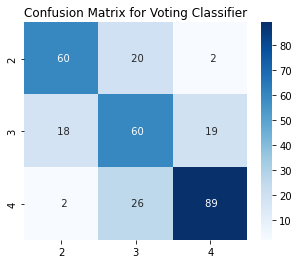

In [32]:
plot_conf_matrix(y_test,y_test_ensemble,unique_class_label, title="Confusion Matrix for " + "Voting Classifier")

In [33]:
test_result_df = pd.DataFrame({'Classifier' :  clfList,
                          'Testing_Accuracy': test_acc_score,
                          'Testing_F1-score': test_f1_score                          
                          })    
test_result_df.sort_values(by="Testing_Accuracy", ascending=False)

,Classifier,Testing_Accuracy,Testing_F1-score
3,GradientBoostingClassifier,0.716216,0.716830
1,XGBClassifier,0.712838,0.714441
4,VotingClassifier,0.706081,0.708869
2,LogisticRegression,0.675676,0.675500
0,RandomForestClassifier,0.672297,0.671720


#### Prediction on Asia Developed Dataset

In [34]:
asia_df = pd.read_csv('https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Datasheets/3_Modelling/Generalization_Check_Asia_Developed.csv').set_index("SecId")
asia_df = morningStarUtilities.createSize_InvestmentTypeFeature(asia_df)
asia_df['Ratings_reset'] = asia_df['StarRatingM255'].apply(lambda x : 2 if(x in (1,2)) else (4 if(x in (4,5)) else 3))

In [35]:
asia_df[asia_df.FundTNAV.isnull()]

,Name,StarRatingM255,SustainabilityRank,CategoryName,Yield_M12,GBRReturnW1,GBRReturnM1,GBRReturnM3,GBRReturnM6,GBRReturnM0,GBRReturnM12,GBRReturnM36,GBRReturnM60,MaxFrontEndLoad,OngoingCostActual,TransactionFeeActual,ManagerTenure,FundTNAV,EquityStyleBox,AverageMarketCapital,MorningstarRiskM255,AlphaM36,BetaM36,R2M36,StandardDeviationM36,SharpeM36,ReturnProfilePreservation,ReturnProfileIncome,ReturnProfileHedging,TrackRecordExtension,Size,Style,Ratings_reset
SecId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F00001071Q,BIEF Emerging Markets A GBP Acc,4,2,Global Emerging Markets Equity,0.62047,1.43,1.64,-3.35,-7.72,0.09,10.79,10.05,NaN,NaN,1.12,1.17,24.08,NaN,2,28614.24791,4,2.47,1.02,89.7,16.24,0.66,3,1,3.0,False,1,2,4


In [36]:
asia_df.drop(index='F00001071Q',inplace=True)


In [37]:
X_asia = asia_df[imp_features]
y_asia = asia_df['Ratings_reset']
X_asia_scaled = scaler.transform(X_asia)

In [38]:
X_asia.isnull().sum()

SustainabilityRank      0
GBRReturnM1             0
GBRReturnM3             0
GBRReturnM0             0
GBRReturnM36            0
OngoingCostActual       0
TransactionFeeActual    0
FundTNAV                0
AverageMarketCapital    0
MorningstarRiskM255     0
AlphaM36                0
BetaM36                 0
StandardDeviationM36    0
SharpeM36               0
Size                    0
Style                   0
dtype: int64

Accuracy Score for RandomForestClassifier  0.6412037037037037
F1 Score for RandomForestClassifier  0.6126052270694828
Accuracy Score for XGBClassifier  0.6666666666666666
F1 Score for XGBClassifier  0.6433886559120076
Accuracy Score for LogisticRegression  0.6342592592592593
F1 Score for LogisticRegression  0.6116601149568955
Accuracy Score for GradientBoostingClassifier  0.6527777777777778
F1 Score for GradientBoostingClassifier  0.6277230752489003


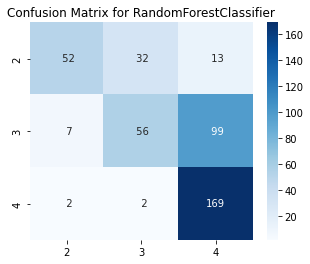

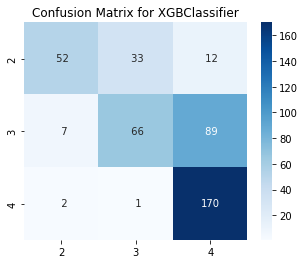

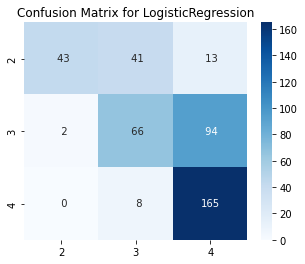

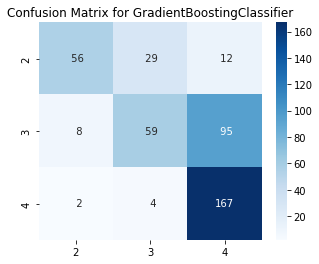

In [39]:
test_acc_score=[]
test_f1_score=[]
clfList = [clf.__class__.__name__  for clf in clfs]


def run_predict_for_untrainedData(clf):
  if clf.__class__.__name__ in scaled_clf:   
    y_pred = clf.predict(X_asia_scaled)
  else:
    y_pred = clf.predict(X_asia)
  plot_conf_matrix(y_asia,y_pred,unique_class_label, title="Confusion Matrix for " + clf.__class__.__name__)
  print("Accuracy Score for " +  clf.__class__.__name__ + "  " 
        + str(accuracy_score(y_asia,y_pred)) )
  print("F1 Score for " + clf.__class__.__name__ + "  " + 
        str(f1_score(y_asia, y_pred, average='weighted')))
  
  test_acc_score.append(accuracy_score(y_asia,y_pred))
  test_f1_score.append(f1_score(y_asia, y_pred, average='weighted'))
  
for clf in clfs:
  run_predict_for_untrainedData(clf)



In [40]:
y_test_ensemble = ensemble.predict(X_asia_scaled)

In [41]:
test_acc_score.append(accuracy_score(y_asia, y_test_ensemble))
test_f1_score.append(f1_score(y_asia, y_test_ensemble, average='weighted'))
clfList.append("VotingClassifier")

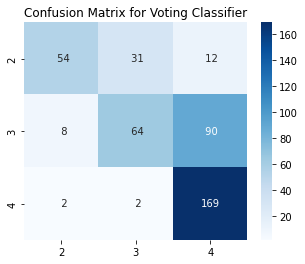

In [42]:
plot_conf_matrix(y_asia,y_test_ensemble,unique_class_label, title="Confusion Matrix for " + "Voting Classifier")

In [43]:
testing_result_df = pd.DataFrame({'Classifier' :  clfList,
                          'Testing_Accuracy': test_acc_score,
                          'Testing_F1-score': test_f1_score                          
                          })    
testing_result_df.sort_values(by="Testing_Accuracy", ascending=False)

,Classifier,Testing_Accuracy,Testing_F1-score
1,XGBClassifier,0.666667,0.643389
4,VotingClassifier,0.664352,0.640806
3,GradientBoostingClassifier,0.652778,0.627723
0,RandomForestClassifier,0.641204,0.612605
2,LogisticRegression,0.634259,0.611660
